In [1]:
# import
from shapely.ops import cascaded_union  # , unary_union
import matplotlib.pyplot as plt
import tempfile
import urllib
import base64
import h3
from shapely.geometry import mapping
from geopandas import GeoDataFrame
import xarray as xr
import geopandas
import rtree
import shapely
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# import matplotlib
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

#Functions


def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16, 12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col, edgecolors='none',
                    colormap=colormap, marker=marker, alpha=alpha, figsize=figsize)
    plt.xticks([], [])
    plt.yticks([], [])


def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(
        lambda x: h3.h3_to_parent(x, coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[
        [metric_col, ]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfc


def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]]
    dfk.index = dfk[hex_col]
    dfs = (dfk[hex_col]
           .apply(lambda x: pd.Series(list(h3.k_ring(x, k)))).stack()
           .to_frame('hexk').reset_index(1, drop=True).reset_index()
           .merge(df[[hex_col, metric_col]]).fillna(0)
           .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
           .reset_index()
           .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]

    # weighted smoothing
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col, inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K = len(coef)-1
    for k in range(1, K+1):
        temp2.append((df_agg['hexk']
                      .apply(lambda x: pd.Series(list(h3.hex_ring(x, k)))).stack()
                      .to_frame('hexk').reset_index(1, drop=True).reset_index()
                      ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x: coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(
        index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


Text(0.5, 1.0, '南京市公共设施服务')

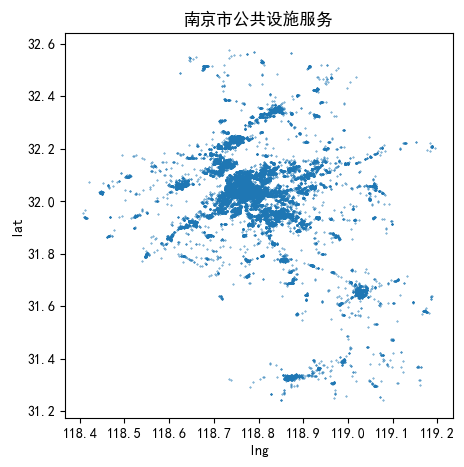

In [2]:
# load the 311 noise complaints
df311 = pd.read_csv(
    r"E:\paper\data\原始数据\全国重点城市POI数据\全国重点城市POI数据\南京\CSV版本\餐饮.csv", encoding='gbk')

# Visualize the 311 noise complaints points
# df311.plot(x='lng', y='lat', style='.', alpha=1, )

df311.plot.scatter(x='lng', y='lat', marker='.', s=0.5, figsize=(5, 5), alpha=1)
plt.title('南京市公共设施服务')
# df311


Text(0.5, 1.0, 'hex-grid: noise complaints')

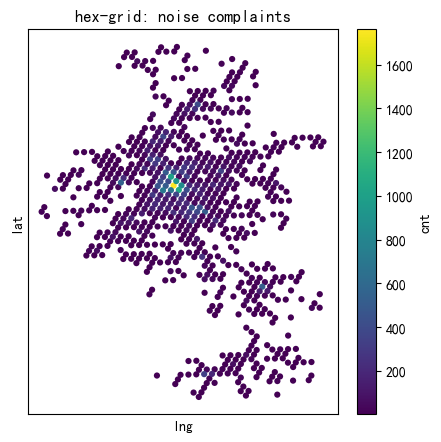

In [4]:
APERTURE_SIZE = 7
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, APERTURE_SIZE), 1)

# aggregate the points
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
df311g['lat'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df311g['lng'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df311g, metric_col='cnt', marker='o', figsize=(5, 5))
plt.title('hex-grid: noise complaints')


In [20]:
df311g

,hex7,cnt,lat,lng
0,873082492ffffff,2,32.509211,118.977728
1,873090241ffffff,5,31.946907,118.469742
2,873090248ffffff,1,31.931204,118.506985
3,87309024cffffff,2,31.947760,118.492115
4,87309024dffffff,23,31.948608,118.514483
...,...,...,...,...
750,87309eda6ffffff,12,31.421060,119.076395
751,87309edb0ffffff,1,31.386141,119.061462
752,87309edb1ffffff,4,31.386976,119.083615
753,87309edb5ffffff,1,31.403604,119.068928


sum sanity check: 1.0


Text(0.5, 1.0, '克里金插值结果')

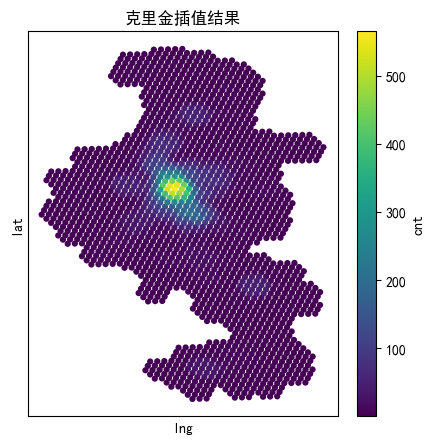

In [5]:
#kring_smoothing
k = 2
df311s = kring_smoothing(df311g, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(df311s, metric_col='cnt', marker='o', figsize=(5, 5))
plt.title('克里金插值结果')


In [7]:
df311s

,hex7,cnt,lat,lng
0,873082490ffffff,0.315789,32.526369,118.985231
1,873082491ffffff,0.105263,32.527039,119.007510
2,873082492ffffff,0.894737,32.509211,118.977728
3,873082493ffffff,0.210526,32.509885,119.000007
4,873082494ffffff,0.263158,32.542851,118.970449
...,...,...,...,...
1914,87309edb2ffffff,0.789474,31.368673,119.053996
1915,87309edb3ffffff,0.736842,31.369511,119.076150
1916,87309edb4ffffff,1.631579,31.402770,119.046770
1917,87309edb5ffffff,1.578947,31.403604,119.068928


In [1]:
df311s[['hex7', 'cnt']].to_csv('temp.csv', index=False)

NameError: name 'df311s' is not defined

In [4]:
# 递归搜索文件夹下的所有文件，添加到一个列表种
import os


def list_files(res, startpath, startStr, endStr):
    for root, dirs, files in os.walk(startpath):
        for name in files:
            if name.endswith(endStr) and name.startswith(startStr):
                if os.path.join(root, name) not in res:
                    res.append(os.path.join(root, name))
        for dir in dirs:
            list_files(res, os.path.join(root, dir), startStr, endStr)


In [5]:
oriningFile = []
list_files(oriningFile, r'E:\paper\data\原始数据\全国重点城市POI数据\全国重点城市POI数据\南京\CSV版本', '', '.csv')


In [12]:
import ntpath

print(ntpath.basename(oriningFile[0]).split('.')[0])

住宿服务


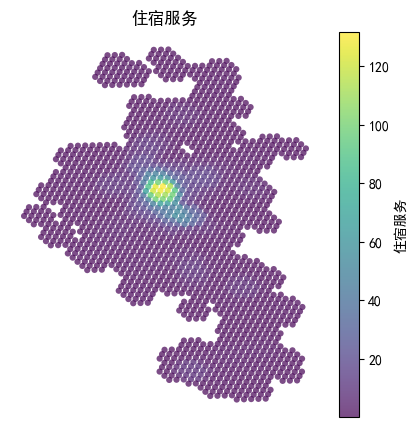

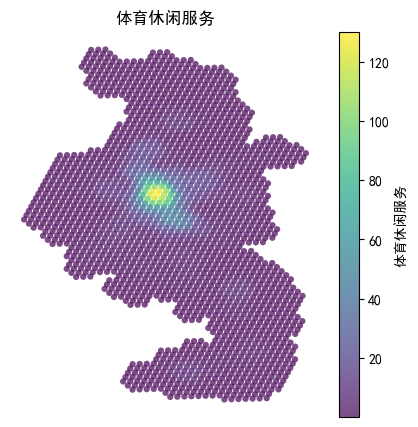

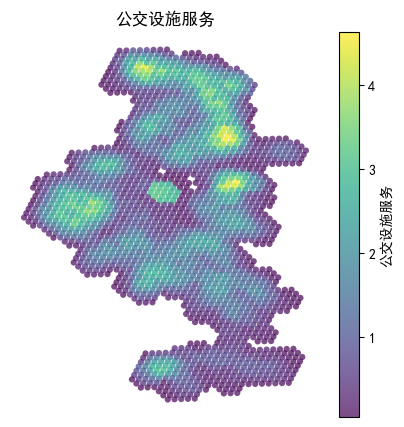

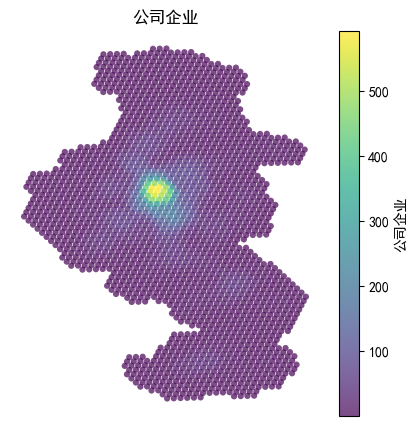

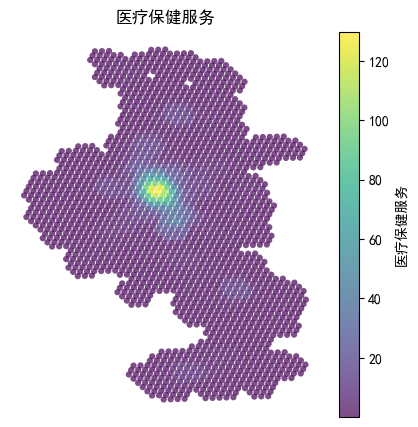

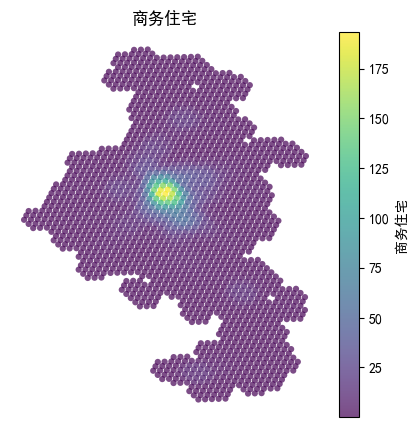

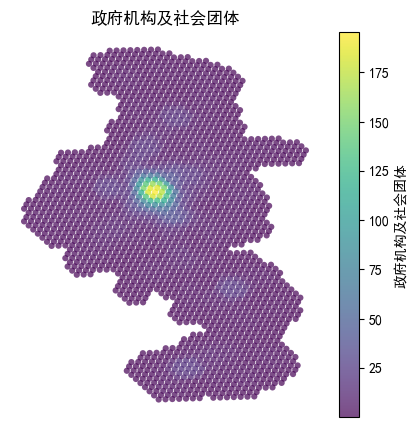

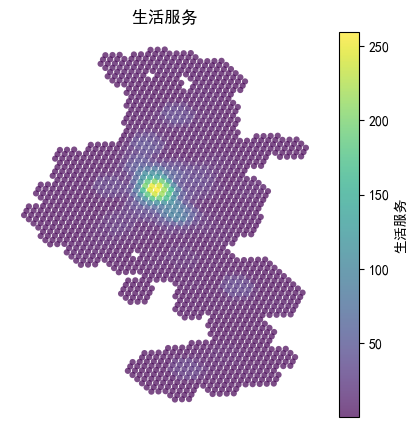

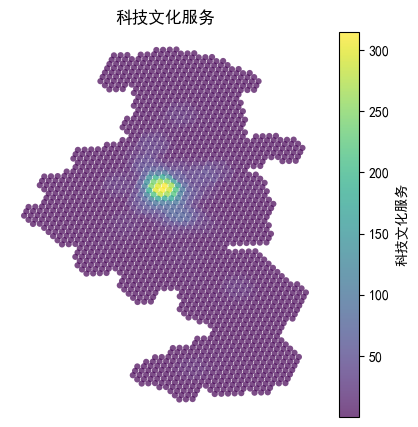

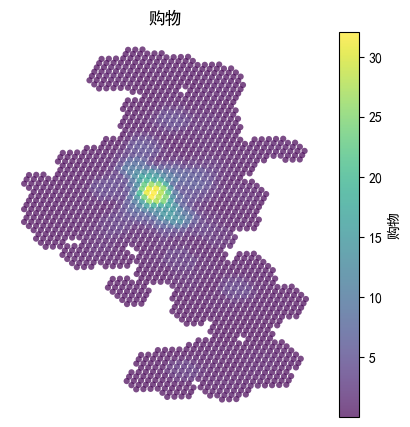

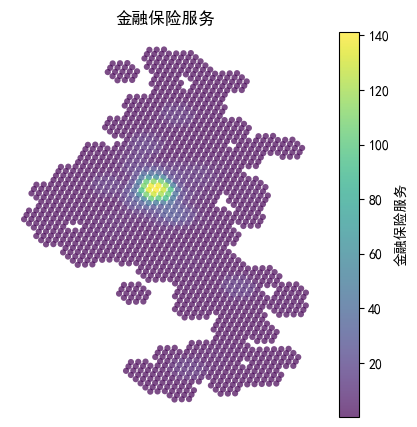

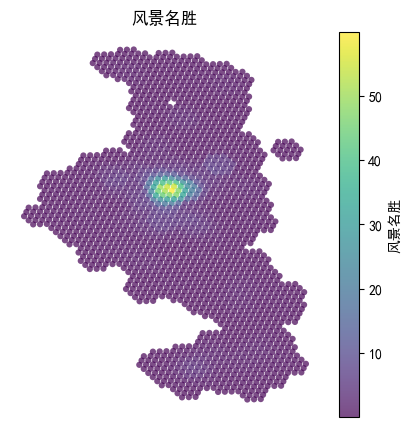

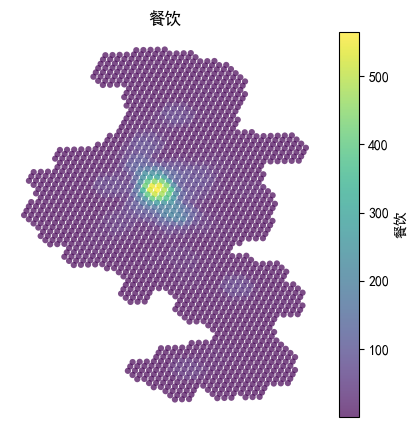

In [64]:
import ntpath

APERTURE_SIZE = 7
hex_col = 'hex'+str(APERTURE_SIZE)

res = []
for file in oriningFile:
    name = ntpath.basename(file).split('.')[0]

    temp_df = pd.read_csv(file, encoding='gbk')
    temp_df[hex_col] = temp_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, APERTURE_SIZE), 1)
    
    temp_hex = temp_df.groupby(hex_col).size().to_frame(name).reset_index()
    temp_hex['lat'] = temp_hex[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    temp_hex['lng'] = temp_hex[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

    temp_df_kring = kring_smoothing(temp_hex, hex_col, metric_col=name, k = 2)


    # plot_scatter(temp_df_kring, metric_col=name,
    #                     marker='o', figsize=(5, 5))
    ax = temp_df_kring.plot.scatter(x='lng', y='lat', c=name, title=name, edgecolors='none',
                    colormap='viridis', marker='o', alpha=0.7, figsize=(5, 5))
    ax.set_axis_off()  # 去掉坐标轴和边框
    # ax.legend().remove()  # 去掉图例
    
    # plt.savefig('temp_png/' + name + '.png', dpi=200, transparent=True, bbox_inches='tight')


In [44]:
from functools import reduce

result = reduce(lambda left, right: pd.merge(left, right, on=['hex7', 'lat', 'lng'], how='outer'), res)
result = result.fillna(0)
result


,hex7,住宿服务,lat,lng,体育休闲服务,公交设施服务,公司企业,医疗保健服务,商务住宅,政府机构及社会团体,生活服务,科技文化服务,购物,金融保险服务,风景名胜,餐饮
0,873082490ffffff,0.105263,32.526369,118.985231,0.210526,1.736842,1.157895,0.368421,0.105263,0.789474,0.315789,0.263158,0.105263,0.000000,0.157895,0.315789
1,873082491ffffff,0.052632,32.527039,119.007510,0.105263,1.421053,0.473684,0.052632,0.000000,0.263158,0.263158,0.157895,0.105263,0.000000,0.157895,0.105263
2,873082492ffffff,0.421053,32.509211,118.977728,0.578947,1.789474,1.684211,0.578947,0.368421,1.210526,0.473684,0.631579,0.315789,0.105263,0.947368,0.894737
3,873082493ffffff,0.105263,32.509885,119.000007,0.157895,2.105263,0.684211,0.315789,0.157895,0.526316,0.421053,0.368421,0.210526,0.105263,0.684211,0.210526
4,873082494ffffff,0.052632,32.542851,118.970449,0.157895,1.157895,1.105263,0.315789,0.000000,0.526316,0.315789,0.210526,0.105263,0.000000,0.105263,0.263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,873091b31ffffff,0.000000,32.461751,119.088813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000
2216,873091b33ffffff,0.000000,32.444593,119.081315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000
2217,873093353ffffff,0.000000,31.196272,119.045815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000
2218,873093358ffffff,0.000000,31.198002,119.090089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000


In [24]:
result.columns.tolist()


['hex7',
 '住宿服务',
 'lat',
 'lng',
 '体育休闲服务',
 '公交设施服务',
 '公司企业',
 '医疗保健服务',
 '商务住宅',
 '政府机构及社会团体',
 '生活服务',
 '科技文化服务',
 '购物',
 '金融保险服务',
 '风景名胜',
 '餐饮']

In [51]:
result = result.reindex(columns=['hex7', 'lat',
                        'lng',
                        '住宿服务',
                        
                        '体育休闲服务',
                        '公交设施服务',
                        '公司企业',
                        '医疗保健服务',
                        '商务住宅',
                        '政府机构及社会团体',
                        '生活服务',
                        '科技文化服务',
                        '购物',
                        '金融保险服务',
                        '风景名胜',
                        '餐饮'])


In [50]:
result

,hex7,住宿服务,lat,lng,体育休闲服务,公交设施服务,公司企业,医疗保健服务,商务住宅,政府机构及社会团体,生活服务,科技文化服务,购物,金融保险服务,风景名胜,餐饮
0,873082490ffffff,0.105263,32.526369,118.985231,0.210526,1.736842,1.157895,0.368421,0.105263,0.789474,0.315789,0.263158,0.105263,0.000000,0.157895,0.315789
1,873082491ffffff,0.052632,32.527039,119.007510,0.105263,1.421053,0.473684,0.052632,0.000000,0.263158,0.263158,0.157895,0.105263,0.000000,0.157895,0.105263
2,873082492ffffff,0.421053,32.509211,118.977728,0.578947,1.789474,1.684211,0.578947,0.368421,1.210526,0.473684,0.631579,0.315789,0.105263,0.947368,0.894737
3,873082493ffffff,0.105263,32.509885,119.000007,0.157895,2.105263,0.684211,0.315789,0.157895,0.526316,0.421053,0.368421,0.210526,0.105263,0.684211,0.210526
4,873082494ffffff,0.052632,32.542851,118.970449,0.157895,1.157895,1.105263,0.315789,0.000000,0.526316,0.315789,0.210526,0.105263,0.000000,0.105263,0.263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,873091b31ffffff,0.000000,32.461751,119.088813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000
2216,873091b33ffffff,0.000000,32.444593,119.081315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000
2217,873093353ffffff,0.000000,31.196272,119.045815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000
2218,873093358ffffff,0.000000,31.198002,119.090089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000


In [52]:
result.to_csv('nanjing_poi.csv', index=False, encoding='utf-8')


